# ECE 285 - Final Project
## Implementation of EmerDiff for Semantic Segmentation
### Name: Pushkal Mishra
### PID: A69033424

This project is an implementation of the [EmerDiff architecture](https://kmcode1.github.io/Projects/EmerDiff/) which uses attention map modulation for semantic segmentation using Stable Diffusion as the backbone architecture.

The model is trained on the CARLA dataset, collected from an [earlier project](https://wcsng.ucsd.edu/c-shenron-demo/).

## Importing the necessary libraries

In [1]:
import os
import cv2
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.cluster import KMeans
from collections import defaultdict
from transformers import CLIPTextModel, CLIPTokenizer
from torchvision.transforms.functional import pil_to_tensor
from diffusers import DDIMScheduler, AutoencoderKL, UNet2DConditionModel

np.random.seed(123)

## Setting CUDA Visibility

In [2]:
# set the cuda visible device to cuda:0
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Loading an image from the CARLA dataset

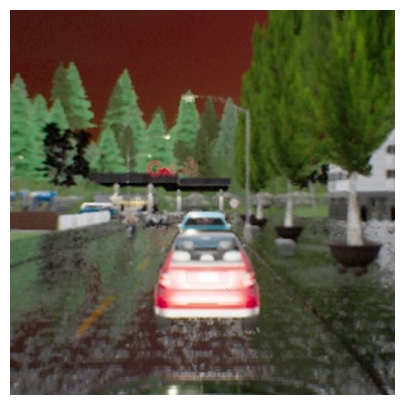

tensor(-1., device='cuda:0') tensor(1., device='cuda:0')


In [3]:
# Load CARLA dataset
# img_path = "/home/pushkalm11/Courses/ece285/Project/dataset/s1_2025-03-05/s1_Town01_Rep1/Town01_Scenario1_route0_03_05_14_14_18/rgb/0110.jpg"
# img_path = "/home/pushkalm11/Courses/ece285/Project/dataset/images/045119.png"
img_path = "/home/pushkalm11/Courses/ece285/Project/dataset/images/070853.png"
# img_path = "/home/pushkalm11/Courses/ece285/Project/dataset/images/069729.png"
save_idx = 3

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image[:, 512 - 128 : 512 + 128, :]

# convert to PIL image
image = Image.fromarray(image)
image_2 = image.resize((512, 512), resample=Image.LANCZOS)

img = pil_to_tensor(image_2).cuda().unsqueeze(0).float() / 255.0 * 2.0 - 1.0

# show both images side by side
plt.figure(figsize=(8, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(image)
# plt.axis('off')
# plt.subplot(1, 2, 2)
plt.imshow(image_2)
plt.axis('off')
plt.savefig(f"./results/{save_idx}-original.png", bbox_inches='tight', dpi=300, pad_inches=0)
plt.show()

print(img.min(), img.max())

## Default Configurations for EmerDiff

Here is a list of available configurations for EmerDiff:
- `lambda`: 
    This is a multiplication constant that is used to scale the mask that modulates the attention map. The attention maps are modulated as `attention_map += lambda * mask`.

- `num_mask`:
    This is the number of masks that are generated via the k-Means algorithm on the attention maps. Each of the generated masks is used to modulate the attention map to find the semantically similar pixels in the original image.

- `text_prompt`:
    This is the text prompt given as input to Stable Diffusion. Currently, it is empty as this results in the same image from the Stable Diffusion model.

- `vae_compression_rate`:
    This is the compression rate used for the Variational Auto Encoder.

- `num_inference_steps`:
    This is the number of inference steps used in the Stable Diffusion model. The higher the number of inference steps, the better the quality of the generated denoised image.

- `time_steps`:
    This is an array that contains the time steps for recording the attention maps. Currently, it has a length of 100, i.e. the attention maps are recorded at 100 noise addition cases at t = 0 and they are averaged.

- `inject_mask_time_stamp`:
    This is an array that contains the time steps at which the masks are used to modulate the attention maps. Through the paper's experiments, the authors found t = 281 / 1000 is the best step. Observe that here we are not using 1000 time steps but 50 and so this value is scaled down and stored in `index_to_use`.

- `record_layers`:
    This tuple consists layers at which the attention maps are recorded.

- `inject_mask_perturbations`:
    This tuple consists layers at which the masks are injected into the attention maps. The perturbations are added to the attention maps at these layers. 

In [4]:
# Parameters for mask proposal
# Negative offset for mask proposal
lambda_1 = -10 
# Positive offset for mask proposal
lambda_2 = 10
# Number of segmentation masks
num_mask = 15
# Text prompt for mask proposal
text_prompt = ""

# Compression factor for VAE to produce latent space
vae_compress_rate = 8
# Stable Diffusion Model checkpoint
stable_diffusion_version = "CompVis/stable-diffusion-v1-4"
# CLIP Model checkpoint
clip_version = "openai/clip-vit-large-patch14"

# Number of timesteps for diffusion process
inference_time_steps = 50

# Timesteps for mask proposal
# Perform multiple runs for convergence
time_steps = [0] * 100
# Timestep at which the feature map is injected
inject_mask_time_stamp = [281]
# This is the number of timesteps to use which is scaled down from the 1000 steps in stable diffusion to the inference_time_steps
index_to_use = int(max(inject_mask_time_stamp) // (1000 / inference_time_steps)+1)

# k-means parameters - Standard parameters
n_init = 100
init_algo = "k-means++"
kmeans_algo = "lloyd"

# Layers to record feature maps - This is the first cross-attention layer at the 16x16 resolution
record_layers = [("cross", "up", 0, 0)]
# Layers to inject mask offsets
inject_mask_perturbations = [("cross", "up", 0, 2)]

# EmerDiff Config Dictionary
emerdiff_config = {
    "lambda_1": lambda_1,
    "lambda_2": lambda_2,
    "num_mask": num_mask,
    "text_prompt": text_prompt,
    "time_steps": time_steps,
    "inject_mask_time_stamp": inject_mask_time_stamp,
    "vae_compress_rate": vae_compress_rate,
    "stable_diffusion_version": stable_diffusion_version,
    "clip_version": clip_version,
    "inference_time_steps": inference_time_steps,
    "n_init": n_init,
    "init_algo": init_algo,
    "kmeans_algo": kmeans_algo,
    "record_layers": record_layers,
    "inject_mask_perturbations": inject_mask_perturbations,
    "multiplication_factor": 0.18215, # Used to scale the latent space
    "index_to_use": index_to_use
}

## Importing pre-trained models

List of pre-trained models that are used:
- Variational Auto Encoder (VAE)
- DDIM Stable Diffusion v1.4
- CLIP ViT-L/14 - Text Encoder
- UNet Text-Conditioned model
- K-Means model for mask generation

In [5]:
# Load VAE
VAE = AutoencoderKL.from_pretrained(
    stable_diffusion_version, 
    subfolder = "vae", 
    cache_dir = "./models/").to("cuda")

# Load DDIM scheduler for noise addition and reverse process
ddim = DDIMScheduler.from_pretrained(
    stable_diffusion_version, 
    subfolder = "scheduler", 
    cache_dir = "./models/")
ddim.set_timesteps(
    inference_time_steps,
    device = "cuda")

# Importing CLIP parameters
text_tokenizer = CLIPTokenizer.from_pretrained(
    clip_version, 
    cache_dir = "./models/")
text_encoder = CLIPTextModel.from_pretrained(
    clip_version, 
    cache_dir = "./models/").to("cuda")

# Importing Text-Conditioned UNet
UNet = UNet2DConditionModel.from_pretrained(
    stable_diffusion_version, 
    subfolder = "unet", 
    cache_dir = "./models/").to("cuda")

# k-Means processor
kmeans_classifier = KMeans(
    n_clusters = emerdiff_config["num_mask"], 
    init = emerdiff_config["init_algo"], 
    n_init = emerdiff_config["n_init"], 
    random_state = 1234, 
    algorithm = emerdiff_config["kmeans_algo"])

## Functions to swap out attention layers
These functions are required to swap out the attention layers in the UNet architecture so that they can store and modify the attention maps.


### Description of the functions:

- Class: `NewAttentionBlock`:
    For swapping out the attention blocks in the standard UNet architecture, we wrap the functions that store and modify the attention maps in a new class. The functions in this class are:
    - `store_attention_maps()`:    
        Stores attention queries (and optionally keys) during forward passes from selected cross-attention layers. These are used for clustering mask features or preserving attention structure. Returns possibly modified query, key, and value based on the flags set.

    - `modify_feature_maps()`:
        Applies spatial perturbations to selected feature maps using a learned binary mask and lambda weights. This helps measure how specific attention regions influence the final image. Returns the perturbed hidden states in the original shape.

    - `extract_mask_features()`:
        Aggregates and averages stored query features across timesteps for selected layers. These features are then reshaped into vectors used for k-means clustering to generate low-resolution masks. Returns a 2D tensor of shape `[tokens, features]`.

- `inject_attention()`:
    Replaces default attention forward passes in the U-Net with custom logic that records or modifies attention behavior. It injects hooks into specific attention layers (cross/self, up/down/mid) to enable storing Q/K and applying feature perturbations. Does not return anything; modifies the U-Net in-place.
    Reference: [https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/unet_2d_condition.py](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/unet_2d_condition.py)

In [6]:
"""
Use of each flag:
    - record_mask_embeddings: Record the mask embeddings at the correct timestep for modification
    - record_kqv_attention: Record the original Query and Key for the attention map so that it can be used later while reconstruction
    - use_recorded_kqv_attention: Use the original Query and Key for the attention map so that it can be used later while reconstruction
    - perturb_feature: Perturb the feature maps
"""
layer_dict = {
    # All the flags
    "record_mask_embeddings": False,
    "record_kqv_attention": False,
    "use_recorded_kqv_attention": False,
    "perturb_feature": False,
    # Storing the attention maps
    "stored_attention": defaultdict(lambda: 0),
    "stored_attention_count": defaultdict(lambda: 0),
    "original_kqv_attention": {},
    # Timestep
    "timestep": -1,
    # Layers to record
    "record_layers": emerdiff_config["record_layers"],
    # Layers to perturb
    "perturb_layers": emerdiff_config["inject_mask_perturbations"],
    # Mask
    "mask": None,
    # Lambda
    "lambda_1": emerdiff_config["lambda_1"],
    "lambda_2": emerdiff_config["lambda_2"],
    "mask_list": [],
}

# Defining a class for new attention blocks to store the maps
class NewAttentionBlock:
    def __init__(self, layer_dict):
        self.layer_dict = layer_dict
    
    # Function to store attention maps
    def store_attention_maps(
        self,
        ty = "cross",
        pos = "up",
        res = 0,
        idx = 0,
        query = None,
        key = None,
        value = None
    ):
        if self.layer_dict["record_mask_embeddings"]:
            if (ty, pos, res, idx) in self.layer_dict["record_layers"]:
                fet = query[0].clone().detach().cpu() #[h*w, 768]
                self.layer_dict["stored_attention"][(self.layer_dict["timestep"],ty,pos,res,idx)] += fet
                self.layer_dict["stored_attention_count"][(self.layer_dict["timestep"],ty,pos,res,idx)] += 1
            if self.layer_dict["record_kqv_attention"]:
                # Storing the original Query and Key for the attention map
                self.layer_dict["original_kqv_attention"][(self.layer_dict["timestep"],ty,pos,res,idx)] = (query.detach().clone().cpu(), key.detach().clone().cpu())
            if self.layer_dict["use_recorded_kqv_attention"]:
                stored_query, stored_key = self.layer_dict["original_kqv_attention"][(self.layer_dict["timestep"],ty,pos,res,idx)]
                query[:] = stored_query[0].to("cuda")
                key[:] = stored_key[0].to("cuda")
        return query, key, value

    # Function to modify the feature maps
    def modify_feature_maps(
        self,
        hidden_states,
        ty = "cross",
        pos = "up",
        res = 0,
        idx = 0,
        to_v = None
    ):
        if self.layer_dict["perturb_feature"] and ((ty, pos, res, idx) in self.layer_dict["perturb_layers"]):
            original_shape = hidden_states.shape
            if len(original_shape) == 4:
                hidden_states = hidden_states.reshape((hidden_states.shape[0], hidden_states.shape[1], -1)).permute((0, 2, 1))
            # Reshape the mask to the same shape as the hidden states
            mask = self.layer_dict["mask"].reshape((1, -1, 1))
            if hidden_states.shape[0] == 2:
                lam = torch.from_numpy(np.array([self.layer_dict["lambda_1"], self.layer_dict["lambda_2"]])).float().reshape(2, 1, 1).to("cuda")
            else:
                lam = torch.from_numpy(np.array([self.layer_dict["lambda_1"]])).float().reshape(1, 1, 1).to("cuda")
            
            # Perturb the feature maps - Main contribution of the EmerDiff architecture
            hidden_states = hidden_states + lam * mask
            if len(original_shape) == 4:
                hidden_states = hidden_states.permute((0,2,1)).reshape(original_shape)
        return hidden_states
    # Function to extract out the mask features
    def extract_mask_features(
        self
    ):
        fet = []
        for (k, v) in self.layer_dict["stored_attention"].items():
            # Here we are taking the mean of the attention maps at the correct timestep
            # Normalization is necessary to stabilize and avoid drift
            fet.append(v.unsqueeze(0) / self.layer_dict["stored_attention_count"][k])
        fet = torch.cat(fet, dim=0)
        fet = fet.permute((1,0,2))
        fet = fet.reshape((fet.shape[0], -1))
        return fet

new_attention_block = NewAttentionBlock(layer_dict)

In [7]:
# This code has been taken from an existing github repository which follows the UNet Text-conditioned architecture
# The code has been modified to store the attention maps and modify the feature maps
def inject_attention(unet, new_attention_block):
    def new_forward_attention(ty = "cross", pos = "up", res=0, idx = 0):
        def forward(attn, hidden_states, encoder_hidden_states=None, attention_mask=None):
            batch_size, sequence_length, _ = (
                hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
            )
            inner_dim = hidden_states.shape[-1]
            query = attn.to_q(hidden_states) #(batch, seq_len, num_heads*head_dim)
            if encoder_hidden_states is None:
                encoder_hidden_states = hidden_states
            key = attn.to_k(encoder_hidden_states) #(batch, seq_len, num_heads*head_dim)
            value = attn.to_v(encoder_hidden_states) #(batch, seq_len, num_heads*head_dim)
            head_dim = inner_dim // attn.heads

            #store qkv
            query, key, value = new_attention_block.store_attention_maps(ty, pos, res, idx, query, key, value)

            query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2) #(batch, num_heads, seq_len, head_dim)
            key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
            value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

            hidden_states = F.scaled_dot_product_attention(
                query, key, value, attn_mask=attention_mask
            )

            hidden_states = hidden_states.transpose(1, 2).reshape(batch_size, -1, attn.heads * head_dim) #(batch, seq_len, num_heads*head_dim)
            hidden_states = hidden_states.to(query.dtype)

            # linear proj
            hidden_states = attn.to_out[0](hidden_states)

            #perturb the output
            hidden_states = new_attention_block.modify_feature_maps(hidden_states, ty, pos, res, idx, None)

            return hidden_states
        return forward
    def inject_block(blocks=unet.up_blocks, pos="up"):
        #ref: https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/unet_2d_condition.py
        res = -1
        if pos == "mid":
            children = [blocks]
        else:
            children = blocks.children()
        for net_ in children:
            if net_.__class__.__name__ in ["CrossAttnUpBlock2D","CrossAttnDownBlock2D","UNetMidBlock2DCrossAttn"]:
                res += 1
                idx = -1
                for atn in net_.attentions:
                        if atn.__class__.__name__ == "Transformer2DModel":
                            idx += 1
                            for block in atn.transformer_blocks:
                                if block.__class__.__name__ == "BasicTransformerBlock":
                                    #self attention
                                    if block.attn1.processor.__class__.__name__ == "AttnProcessor2_0":
                                        block.attn1.processor = new_forward_attention(ty = "self", pos = pos, res = res, idx = idx)
                                    #cross attention
                                    if block.attn2.processor.__class__.__name__ == "AttnProcessor2_0":
                                        block.attn2.processor = new_forward_attention(ty="cross", pos = pos, res = res, idx = idx)
        return blocks
    unet.up_blocks = inject_block(unet.up_blocks, pos="up")
    unet.down_blocks = inject_block(unet.down_blocks, pos="down")
    unet.mid_block = inject_block(unet.mid_block, pos="mid")
    return unet

### Injecting the attention maps into the UNet architecture

In [8]:
UNet = inject_attention(UNet, new_attention_block)

## Functions for Forward and Reverse DDPM process
These functions are copied over from the original implementation of the DDPM process, can be found here: [https://github.com/inbarhub/DDPM_inversion/blob/main/ddm_inversion/inversion_utils.py](https://github.com/inbarhub/DDPM_inversion/blob/main/ddm_inversion/inversion_utils.py).

### Description of the functions:

- `sample_xts_from_x0()`:
    Generates noisy latent samples `x_t` from clean latent `x_0` by adding scheduled Gaussian noise across timesteps. Used to simulate the forward diffusion process for inversion.

- `get_variance()`:
    Computes the noise variance at a specific timestep using the scheduler’s cumulative alpha values. Needed for reverse sampling and DDIM step calculations.

- `inversion_forward_process()`:
    Performs DDPM inversion by simulating the forward process from `x₀` to `x_T`, then reconstructing noise vectors `z` via U-Net predictions at each step. Returns noisy latents, noise vectors, and timesteps.

- `reverse_step()`:
    Executes a single DDIM denoising step from `x_t` to `x_{t-1}` using predicted noise, diffusion schedule, and optional noise scaling. Core operation for controlled reverse generation.

In [9]:
def sample_xts_from_x0(unet, scheduler, x0, num_inference_steps, rng):
    alpha_bar = scheduler.alphas_cumprod
    sqrt_one_minus_alpha_bar = (1-alpha_bar) ** 0.5
    variance_noise_shape = (
            num_inference_steps,
            x0.shape[-3],
            x0.shape[-2],
            x0.shape[-1])

    timesteps = scheduler.timesteps.to("cuda")
    t_to_idx = {int(v):k for k,v in enumerate(timesteps)}
    xts = torch.zeros(variance_noise_shape).to(x0.device)
    for t in reversed(timesteps):
        idx = t_to_idx[int(t)]
        # print(xts.shape, x0.shape)
        xts[idx] = x0 * (alpha_bar[t] ** 0.5) + torch.randn(x0.shape, generator=rng).to("cuda") * sqrt_one_minus_alpha_bar[t]
    xts = torch.cat([xts, x0],dim = 0)

    return xts

def get_variance(scheduler, timestep):
    prev_timestep = timestep - scheduler.config.num_train_timesteps // scheduler.num_inference_steps
    alpha_prod_t = scheduler.alphas_cumprod[timestep]
    alpha_prod_t_prev = scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.final_alpha_cumprod
    beta_prod_t = 1 - alpha_prod_t
    beta_prod_t_prev = 1 - alpha_prod_t_prev
    variance = (beta_prod_t_prev / beta_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev)
    return variance

def inversion_forward_process(unet, scheduler, x0,
                              uncond_embedding,
                              etas = 1.0,
                              num_inference_steps=50,
                              ddpm_seed = 42
                             ):

    timesteps = scheduler.timesteps.to("cuda")
    variance_noise_shape = (
        num_inference_steps,
        x0.shape[-3],
        x0.shape[-2],
        x0.shape[-1])
    rng = torch.Generator().manual_seed(ddpm_seed)

    etas = [etas]*scheduler.num_inference_steps
    #generate noisy samples xts
    # print(x0.shape)
    xts = sample_xts_from_x0(unet, scheduler, x0, num_inference_steps=num_inference_steps, rng = rng)
    alpha_bar = scheduler.alphas_cumprod
    zs = torch.zeros(size=variance_noise_shape, device="cuda") #[50, 4, 64, 64]

    t_to_idx = {int(v):k for k,v in enumerate(timesteps)}
    xt = x0

    for t in timesteps:
        idx = t_to_idx[int(t)]

        xt = xts[idx][None]

        with torch.no_grad():
            out = unet.forward(xt, timestep =  t, encoder_hidden_states = uncond_embedding)

        noise_pred = out.sample

        xtm1 =  xts[idx+1][None]
        pred_original_sample = (xt - (1-alpha_bar[t])  ** 0.5 * noise_pred ) / alpha_bar[t] ** 0.5
        prev_timestep = t - scheduler.config.num_train_timesteps // scheduler.num_inference_steps
        alpha_prod_t_prev = scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.final_alpha_cumprod
        variance = get_variance(scheduler, t)
        pred_sample_direction = (1 - alpha_prod_t_prev - etas[idx] * variance ) ** (0.5) * noise_pred
        mu_xt = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction
        z = (xtm1 - mu_xt ) / ( etas[idx] * variance ** 0.5 )
        zs[idx] = z
        xtm1 = mu_xt + ( etas[idx] * variance ** 0.5 )*z
        xts[idx+1] = xtm1
    return xts, zs, timesteps

# Simulating one step of the reverse diffusion process
def reverse_step(scheduler, model_output, timestep, sample, eta, variance_noise):
    prev_timestep = timestep - scheduler.config.num_train_timesteps // scheduler.num_inference_steps
    alpha_prod_t = scheduler.alphas_cumprod[timestep]
    alpha_prod_t_prev = scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.final_alpha_cumprod
    beta_prod_t = 1 - alpha_prod_t
    pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
    variance = get_variance(scheduler, timestep)
    std_dev_t = eta * variance ** (0.5)
    model_output_direction = model_output
    pred_sample_direction = (1 - alpha_prod_t_prev - eta * variance) ** (0.5) * model_output_direction
    prev_sample = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction
    if eta > 0:
        sigma_z =  eta * variance ** (0.5) * variance_noise
        prev_sample = prev_sample + sigma_z

    return prev_sample

## Main EmerDiff Process

Here we define two more functions, described below:

- `fwd_stable_diffusion()`:
    This function performs the forward diffusion process using the Stable Diffusion model. It takes the input image and generates noisy latents at each timestep. Further it denoises the latents using the UNet model. This function is used to trigger the saving of attention maps.

- `reverse_diffusion_one_step()`:
    This function performs a single reverse diffusion step using the UNet model. It takes the noisy latents and denoises them to generate the final image. This function is used to trigger the injection of masks into the attention maps.

In [10]:
# Forward Process of Stable Diffusion along with UNet denoising to record attention maps
def fwd_stable_diffusion(
    latent, 
    time_steps, 
    new_attention_block):
    # Random number generator which is shared across all timesteps
    random_number_generator = torch.Generator().manual_seed(42)
    # Adding noise to the latent vector at each timestep
    for t in time_steps:
        noise = torch.randn(latent.shape, generator = random_number_generator).to("cuda")
        latent_t = ddim.add_noise(latent, noise, torch.tensor([t]).int())
        new_attention_block.layer_dict["timestep"] = t
        UNet(latent_t, t, encoder_hidden_states = new_attention_block.layer_dict["prompt_embedding"])

# Running one step of the reverse diffusion process
def reverse_diffusion_one_step(
    t, 
    latents, 
    cond1, 
    cond2 = None, 
    z_ddpm = None):
    if cond2 != None:
        text_embeddings  = torch.cat([cond1, cond2])
    else:
        text_embeddings = cond1
    noise_pred = UNet(
                            latents,
                            t,
                            encoder_hidden_states=text_embeddings
                        ).sample
    z_ddpm = z_ddpm.expand(latents.shape[0],-1,-1,-1) #scheduled noise
    return reverse_step(ddim, noise_pred, t, latents, 1.0, z_ddpm) 

## Here is the Forward Pass of the EmerDiff process:

Stepwise description:
- Convert the image to latent space using the VAE.
- Convert the text prompt to CLIP embeddings.
- Trigger the forward diffusion process using the Stable Diffusion model. This will record the attention maps at the specified layers.
- Extract the attention maps from the UNet model and run the k-Means classifier on it.

In [11]:
# Generating Latent Vector embedding from the image
latent = VAE.encode(img)['latent_dist'].mean
latent = latent * emerdiff_config["multiplication_factor"]

# Shape of the original image
h, w = latent.shape[-2], latent.shape[-1]
h, w = h * emerdiff_config["vae_compress_rate"], w * emerdiff_config["vae_compress_rate"]

# Adding text embedding to the layer_dict
text_prompt_tokens = text_tokenizer(
    text_prompt, 
    padding = "max_length", 
    max_length = text_tokenizer.model_max_length, 
    truncation = True, 
    return_tensors = "pt")
text_prompt_embeddings = text_encoder(text_prompt_tokens.input_ids.to("cuda"))[0]
print(f"Shape of prompt embeddings in CLIP space: {text_prompt_embeddings.shape}")
new_attention_block.layer_dict["prompt_embedding"] = text_prompt_embeddings

# Extracting mask for clustering
new_attention_block.layer_dict["record_mask_embeddings"] = True
fwd_stable_diffusion(latent, emerdiff_config["time_steps"], new_attention_block)
new_attention_block.layer_dict["record_mask_embeddings"] = False

# Clustering the features to produce low-resolution segmentation maps
mask_features = new_attention_block.extract_mask_features()
kmeans_classifier.fit(mask_features)
mask_to_id_mapping = torch.from_numpy(kmeans_classifier.labels_).to("cuda")
num_masks = mask_to_id_mapping.max() + 1

Shape of prompt embeddings in CLIP space: torch.Size([1, 77, 768])


Stepwise description:
- Run the forward process and reverse process of noise addition and denoising respectively using the UNet model. Record all the latents at every time step.
- Extract the denoised latents and timesteps.
- Perform step-by-step of reverse diffusion now with the functionality to record the KQV attention maps which will further be used to inject the mask features.

In [12]:
# Run the forward process and track the latents and noise at the timesteps to be used for the final image
index_to_use = emerdiff_config["index_to_use"]
xts, zs, timesteps = inversion_forward_process(
    UNet,
    ddim,
    latent,
    new_attention_block.layer_dict["prompt_embedding"],
    etas = 1.0,
    num_inference_steps = emerdiff_config["inference_time_steps"],
    ddpm_seed = 42
)
xts = xts.unsqueeze(1)
# Excluding the first timestep
xts = xts[-index_to_use-1:-1]
timesteps = timesteps[-index_to_use:]
zs = zs[-index_to_use:]

# Run the reverse process to get the de-noised latents at the timesteps to be used for the final image
with torch.no_grad():
    new_attention_block.layer_dict["record_kqv_attention"] = True
    original_latents = xts[0]
    for i, (xt, t) in enumerate(zip(xts, timesteps)):
        new_attention_block.layer_dict["timestep"] = t
        original_latents = reverse_diffusion_one_step(
            t = t,
            latents = original_latents,
            cond1 = new_attention_block.layer_dict["prompt_embedding"],
            z_ddpm = zs[i]
        )
    new_attention_block.layer_dict["record_kqv_attention"] = False

Stepwise description:
- For every mask, inject the mask features into the attention maps at the specified layers.
- Perform the reverse diffusion process using the UNet model with the modified attention maps.
- Finally, decode the denoised latents to get the final image using the VAE.
- Compute the difference map and store the normalized version.
- Take the argmax of the stored difference maps across different masks to get the final segmentation mask.

In [13]:
# Now that we have the de-noised latents, we can modulate the attention maps for every mask to generate the final image
img_with_mask_id = []
for i in range(emerdiff_config["num_mask"]):
    print(f"Generating the difference map for mask id: {i + 1} / {emerdiff_config['num_mask']}")
    with torch.no_grad():
        # Here we generate the difference map for the mask id i and store them in a list
        # Updating the mask
        new_attention_block.layer_dict["mask"] = (mask_to_id_mapping == i).float().to("cuda")
        new_attention_block.layer_dict["mask_list"].append(new_attention_block.layer_dict["mask"])
        
        # Modifying the latent and generating the difference map
        latent_to_modify = torch.cat([xts[0]]*2, dim = 0)
        # Setting the flag to use the recorded attention maps
        new_attention_block.layer_dict["use_recorded_kqv_attention"] = True
        for i, (xt, t) in enumerate(zip(xts, timesteps)):
            # Setting the timestep
            new_attention_block.layer_dict["timestep"] = t
            # Setting the flag to perturb the feature maps
            new_attention_block.layer_dict["perturb_feature"] = (t in emerdiff_config["inject_mask_time_stamp"])
            # Running the diffusion step
            latent_to_modify = reverse_diffusion_one_step(
                t = t,
                latents = latent_to_modify,
                cond1 = new_attention_block.layer_dict["prompt_embedding"],
                cond2 = new_attention_block.layer_dict["prompt_embedding"],
                z_ddpm = zs[i]
            )
        new_attention_block.layer_dict["use_recorded_kqv_attention"] = False
        new_attention_block.layer_dict["perturb_feature"] = False
        x_modified = VAE.decode(latent_to_modify / emerdiff_config["multiplication_factor"]).sample
        
        # Adding blurring to the image
        x_modified = torchvision.transforms.functional.gaussian_blur(x_modified, kernel_size = 3)
        difference_map = torch.linalg.norm(x_modified[0 : 1] - x_modified[1 : 2], dim = 1)
        img_with_mask_id.append(difference_map.cpu())
    
# Concatenating the difference maps and taking argmax to get the final image
segmented_image = torch.argmax(torch.cat(img_with_mask_id, dim = 0), dim = 0)
print(f"Shape of the segmented image: {segmented_image.shape}")

Generating the difference map for mask id: 1 / 15
Generating the difference map for mask id: 2 / 15
Generating the difference map for mask id: 3 / 15
Generating the difference map for mask id: 4 / 15
Generating the difference map for mask id: 5 / 15
Generating the difference map for mask id: 6 / 15
Generating the difference map for mask id: 7 / 15
Generating the difference map for mask id: 8 / 15
Generating the difference map for mask id: 9 / 15
Generating the difference map for mask id: 10 / 15
Generating the difference map for mask id: 11 / 15
Generating the difference map for mask id: 12 / 15
Generating the difference map for mask id: 13 / 15
Generating the difference map for mask id: 14 / 15
Generating the difference map for mask id: 15 / 15
Shape of the segmented image: torch.Size([512, 512])


## Visualization

Here we visualize the segmented image which is overlayed on top of the original image.

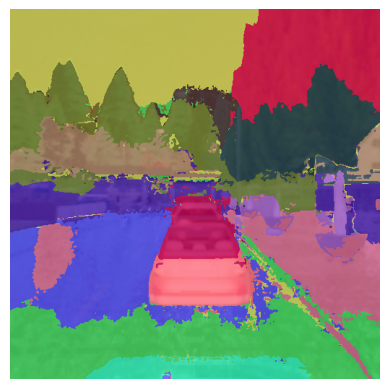

In [14]:
palette = np.random.choice(range(256), size=(1000,3)).astype(np.uint8)
col_img = palette[segmented_image.flatten()].reshape(segmented_image.shape+(3,))
im = np.array(col_img)*0.8+((img[0]+1.0)/2.0*255.0).permute((1,2,0)).cpu().numpy()*0.2
plt.imshow(Image.fromarray(im.astype(np.uint8)))
plt.axis('off')
plt.savefig(f"./results/{save_idx}-segmented.png", bbox_inches='tight', dpi=300, pad_inches=0)
plt.show()

## Visualization

Here we visualize the masks generated by the k-Means algorithm on the attention maps.

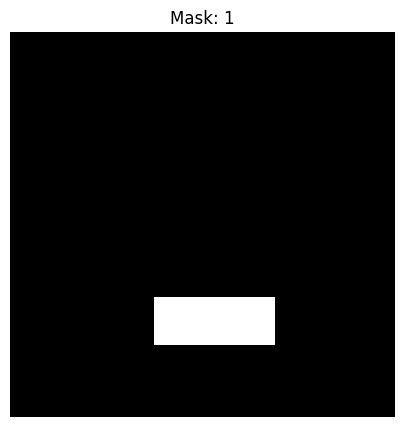

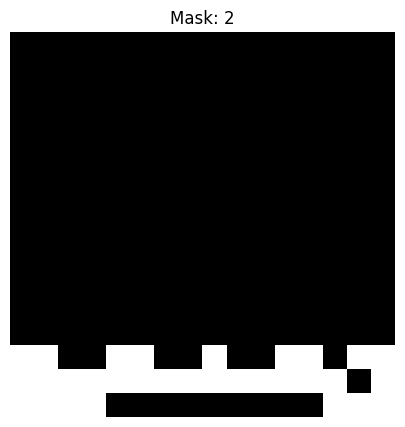

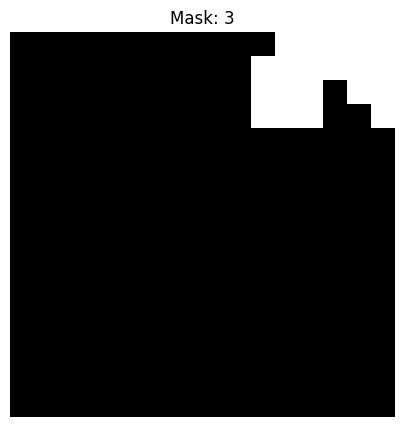

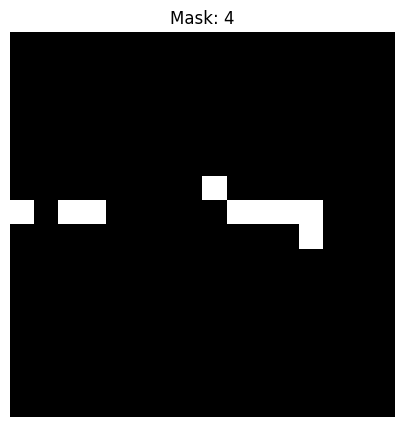

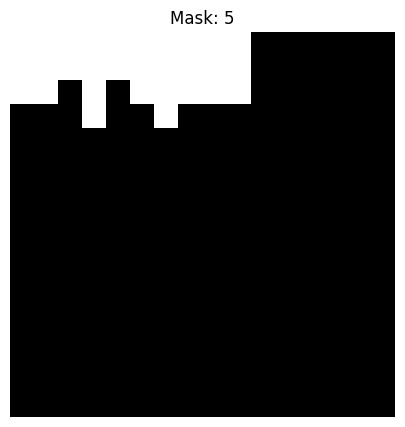

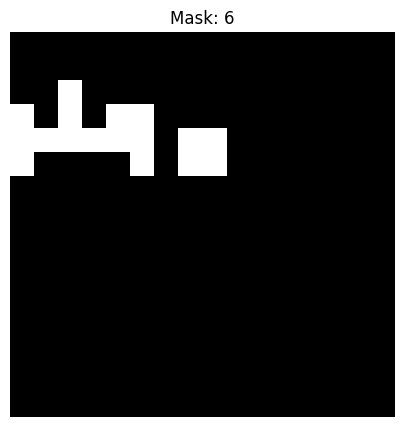

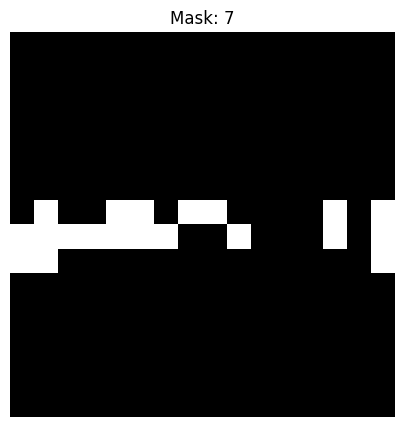

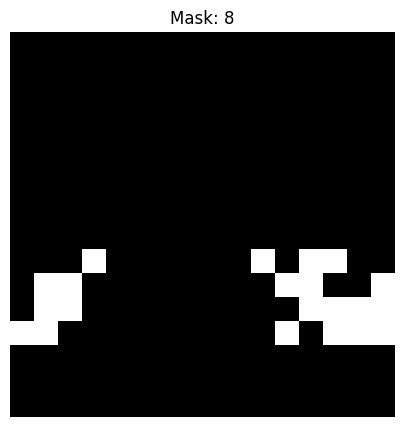

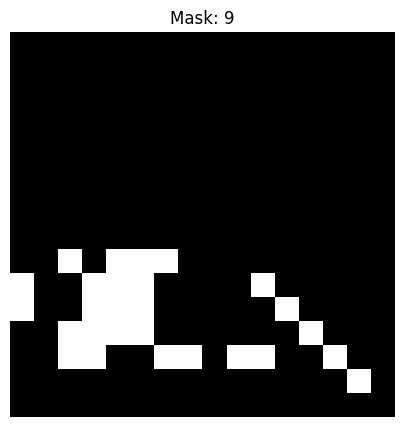

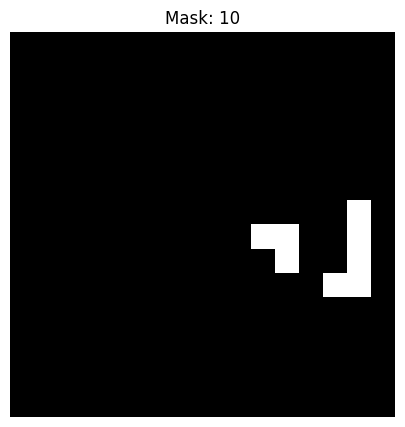

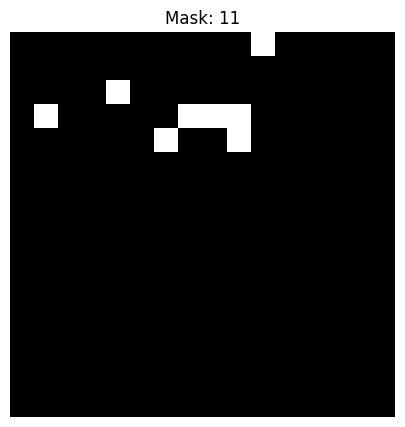

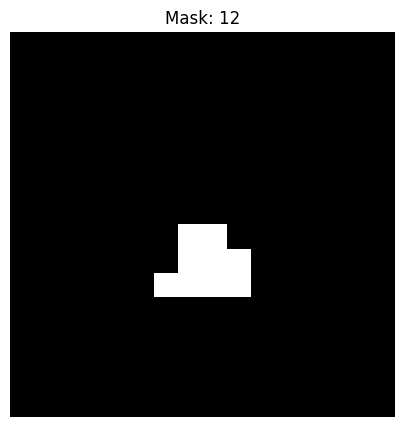

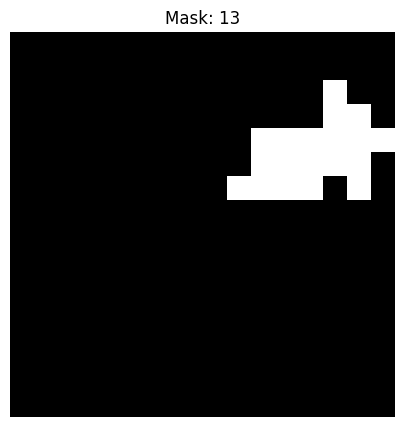

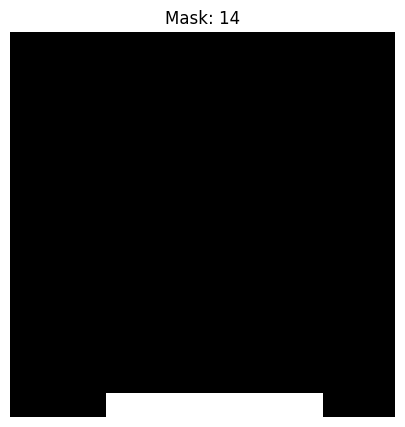

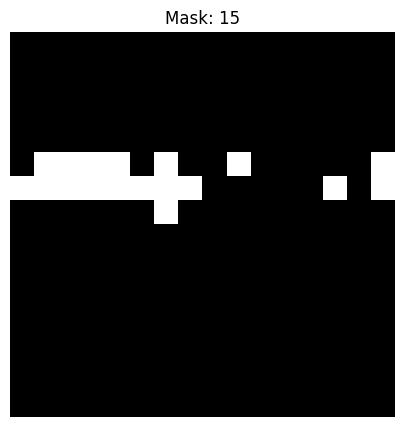

In [ ]:
mask_list = new_attention_block.layer_dict["mask_list"]

for i, mask in enumerate(mask_list):
    mask_plot = mask.detach().cpu().numpy().reshape(16, 16)

    # Plot the mask
    plt.figure(figsize=(8, 5))
    plt.subplot(2, 1, 1)
    plt.imshow(Image.fromarray(im.astype(np.uint8)))
    plt.axis('off')
    plt.subplot(2, 1, 2)
    plt.imshow(mask_plot, cmap = "gray")
    plt.axis('off')
    plt.title(f"Mask: {i + 1}")
    plt.show()

## Comparing against DINO

Using cache found in /home/pushkalm11/.cache/torch/hub/facebookresearch_dino_main


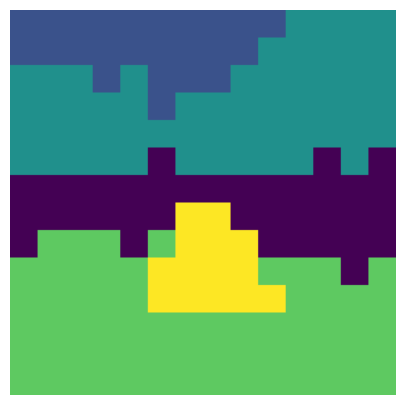

In [16]:
import torchvision.transforms as T

# Load DINO-pretrained ViT (via torchvision)
model = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16')
model.eval().cuda()

# Load and preprocess image
image_for_dino = image.resize((224, 224), resample=Image.LANCZOS)
image_for_dino = pil_to_tensor(image_for_dino).float() / 255.0
image_for_dino = image_for_dino.cuda()

transform = T.Compose([
    T.Normalize(mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
])

input_tensor = transform(image_for_dino).unsqueeze(0).cuda()

# Extract patch tokens (excluding CLS token)
with torch.no_grad():
    output = model.get_intermediate_layers(input_tensor, n=1)[0]  # List of 1 tensor
    patch_tokens = output[:, 1:, :]  # Remove CLS token

# Perform k-means clustering on patch tokens
n_patches = int(patch_tokens.shape[1] ** 0.5)  # 14 for 224x224 input with 16x16 patches
tokens = patch_tokens[0].cpu().numpy()

# KMeans clustering to pseudo-label each patch
k = 5  # number of clusters (segments)
kmeans = KMeans(n_clusters=k, random_state=0).fit(tokens)
labels = kmeans.labels_.reshape(n_patches, n_patches)

# Upsample labels to original image size
segmentation = Image.fromarray(labels.astype(np.uint8)).resize((224, 224), resample=Image.NEAREST)
segmentation = np.array(segmentation)

# Visualize segmentation
plt.figure(figsize=(10, 5))
# plt.imshow(segmentation, cmap="tab20")
plt.imshow(segmentation)
plt.axis("off")
plt.show()

## Comparison against SegFormer

/home/pushkalm11/miniconda3/envs/ece285/lib/python3.10/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


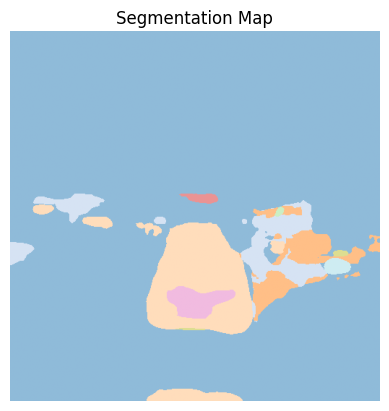

In [17]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import torch

# Load model and processor
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# Prepare image
inputs = processor(images=image_2, return_tensors="pt")

# Get predictions
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_classes, height, width)

# Get predicted segmentation map
upsampled_logits = torch.nn.functional.interpolate(
    logits,
    size=image_2.size[::-1],  # (height, width)
    mode='bilinear',
    align_corners=False
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

plt.imshow(pred_seg.cpu(), cmap='tab20', alpha=0.5)  # Use 'tab20' colormap for better visibility
plt.title("Segmentation Map") 
plt.axis('off')
plt.show()